In [42]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat
import auxiliary_functions

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg
import networkx as nx
import compute_S_rate

In [162]:
events = [(0,1),(2,3),(4,5),(0,2),(0,3),(1,2),(1,3),(0,4),(0,5),(1,4),(1,5),(2,4),(2,5),(3,4),(3,5)]

source_nodes = []
target_nodes = []
starting_times = []
ending_times = []

interval = 0.5
for event in events[0:3]:
     for t in np.arange(0,15,interval):
          source_nodes.append(event[0])
          target_nodes.append(event[1])
          starting_times.append(t)
          ending_times.append(t+interval)
    

for event in events[3:7]:
     for t in np.arange(0,5,interval):
          source_nodes.append(event[0])
          target_nodes.append(event[1])
          starting_times.append(t)
          ending_times.append(t+interval)
    

for event in events[7:11]:
     for t in np.arange(5,10,interval):
          source_nodes.append(event[0])
          target_nodes.append(event[1])
          starting_times.append(t)
          ending_times.append(t+interval)

for event in events[11:15]:
     for t in np.arange(10,15,interval):
          source_nodes.append(event[0])
          target_nodes.append(event[1])
          starting_times.append(t)
          ending_times.append(t+interval)

In [163]:
net = ContTempNetwork(source_nodes=source_nodes, target_nodes=target_nodes, starting_times=starting_times, ending_times=ending_times)

In [164]:
net.events_table

,source_nodes,target_nodes,starting_times,ending_times,durations
0,0,1,0.0,0.5,0.5
1,2,3,0.0,0.5,0.5
2,4,5,0.0,0.5,0.5
3,0,2,0.0,0.5,0.5
4,0,3,0.0,0.5,0.5
...,...,...,...,...,...
205,4,5,14.5,15.0,0.5
206,2,4,14.5,15.0,0.5
207,2,5,14.5,15.0,0.5
208,3,4,14.5,15.0,0.5


In [165]:
static_adjacency_matrix = net.compute_static_adjacency_matrix().toarray() != 0

In [166]:
static_net = nx.Graph(static_adjacency_matrix)

In [167]:
comm = nx.community.greedy_modularity_communities(static_net)

In [168]:
comm

[frozenset({0, 1, 2, 3, 4, 5})]

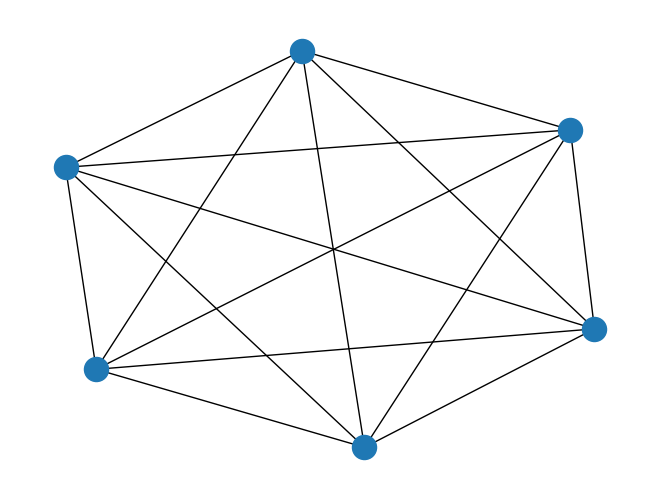

In [190]:
nx.draw(static_net)

# Global Conditional Entropy

In [170]:
selected_lamdas = np.logspace(-5,0,10)

In [171]:
for lamda in selected_lamdas:
    net.compute_inter_transition_matrices(lamda=lamda, random_walk=False)
    net.compute_transition_matrices(lamda=lamda)

In [172]:
for lamda in selected_lamdas:
    net.compute_entropy(lamda = lamda)

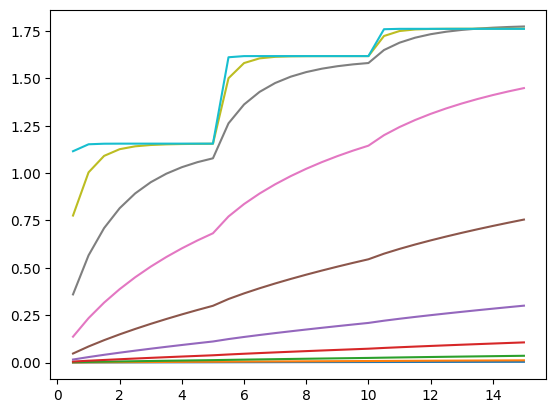

In [173]:
for lamda in net.S.keys():
    plt.plot(net.times[1:], net.S[lamda])

# Window Conditional Entropy

In [174]:
list_S = []
window_size = 4
for lamda in selected_lamdas:
    net.compute_transition_matrices_sliding_window(lamda=lamda, window_size=window_size)
    list_S.append(compute_S_rate.compute_conditional_entropy(net=net, list_T=net.window_T[lamda],
                                    lamda=lamda, force_csr=True,
                                    time_domain= list(np.arange(0,len(net.times) -window_size -1))))

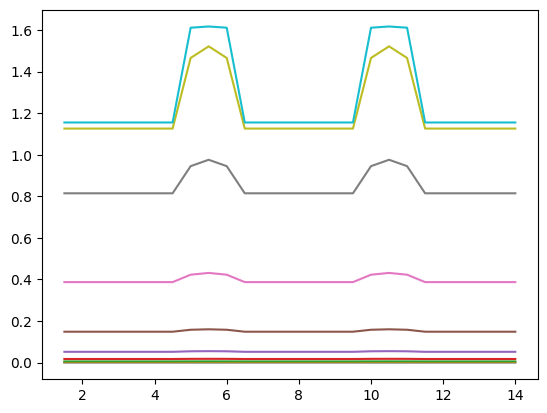

In [178]:
for i, lamda in enumerate(net.S.keys()):
    plt.plot(net.times[1 + window_size // 2:- (window_size // 2)], list_S[i][list(list_S[i].keys())[0]][1:])

In [180]:
print(net.times)
print(list_S[i][list(list_S[i].keys())[0]][1:])

Index([ 0.0,  0.5,  1.0,  1.5,  2.0,  2.5,  3.0,  3.5,  4.0,  4.5,  5.0,  5.5,
        6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0, 10.5, 11.0, 11.5,
       12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0],
      dtype='float64', name='times')
[1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.6112037134686061, 1.6171156722166562, 1.6112037134686061, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.611203713468606, 1.6171156722166562, 1.611203713468606, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397, 1.1551892748588397]


In [182]:
print(net.times[9])
print(list_S[i][list(list_S[i].keys())[0]][8])

4.5
1.6112037134686061


In [179]:
list_S[i][list(list_S[i].keys())[0]][1:]

[1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.6112037134686061,
 1.6171156722166562,
 1.6112037134686061,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.611203713468606,
 1.6171156722166562,
 1.611203713468606,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397,
 1.1551892748588397]

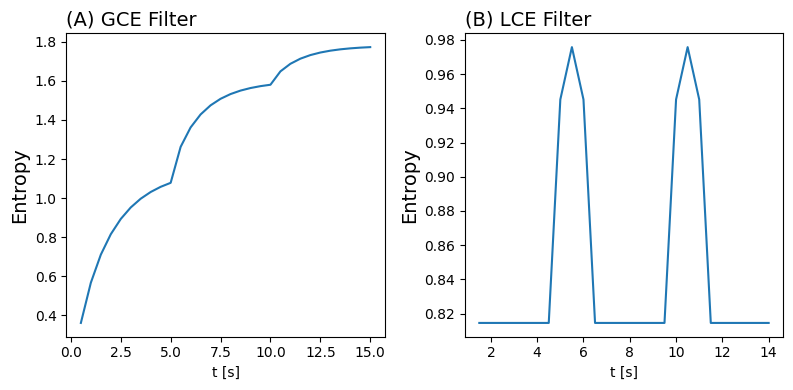

In [ ]:
i = 7

# Start creating the figure
fig = plt.figure(figsize=(16, 4))  # Wider figure for all plots in one row
gs = fig.add_gridspec(1, 4)  # Grid: 1 row, 4 columns

# Column 1: Plot A
ax_a = fig.add_subplot(gs[0, 0])
color = 'lightseagreen'

ax_a.plot(net.times[1:], net.S[selected_lamdas[i]])
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy", fontsize=14)
ax_a.set_title("(A) GCE Filter", loc='left', fontsize=14)


# Column 2: Plot B
ax_b = fig.add_subplot(gs[0, 1])
####### First Plot
ax_b.plot(net.times[1 + window_size // 2:- (window_size // 2)], list_S[i][list(list_S[i].keys())[0]][1:])
ax_b.set_xlabel("t [s]")
ax_b.set_ylabel('Entropy', fontsize=14)
ax_b.set_title('(B) LCE Filter', loc='left', fontsize=14)

# Adjust layout and display
plt.tight_layout()
#plt.savefig('/home/b/skoove/Desktop/toy_example/hexagon_filters_fig.png', format='png', dpi=300, bbox_inches='tight')
plt.show()